## GlADE+ catalog visualization

In this notebook, we use the `healpy` library to visualize the data output from the `parse_catalog` script. We follow the tutorial provided in the [`healpy` documentation](https://healpy.readthedocs.io/en/latest/tutorial.html).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import healpy as hp
import pymaster as nmt

from catalog.utils import GalaxyCatalog, Skymap, MaskedMap
from catalog.cl import AngularPowerSpectrumEstimator

In [2]:
# Notebook settings
save_figures = False

In [3]:
# Constants
nside = 256
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 256 is 0.23 deg


Number of pixels in the map:

In [4]:
npix = hp.nside2npix(nside)
npix

786432

Importing file:

In [5]:
catalog_path = '/Volumes/binadohd/phd/GLADE+/parsed_catalog.hdf5'
#catalog_path = '../data/GLADE+trimmed_parsed.hdf5'
catalog = GalaxyCatalog(catalog_path)

The `skymap` dataset holds the corresponding pixel for each galaxy. In the cell below, we convert this information into an array of length `npix` holding the number of galaxies within each pixel:

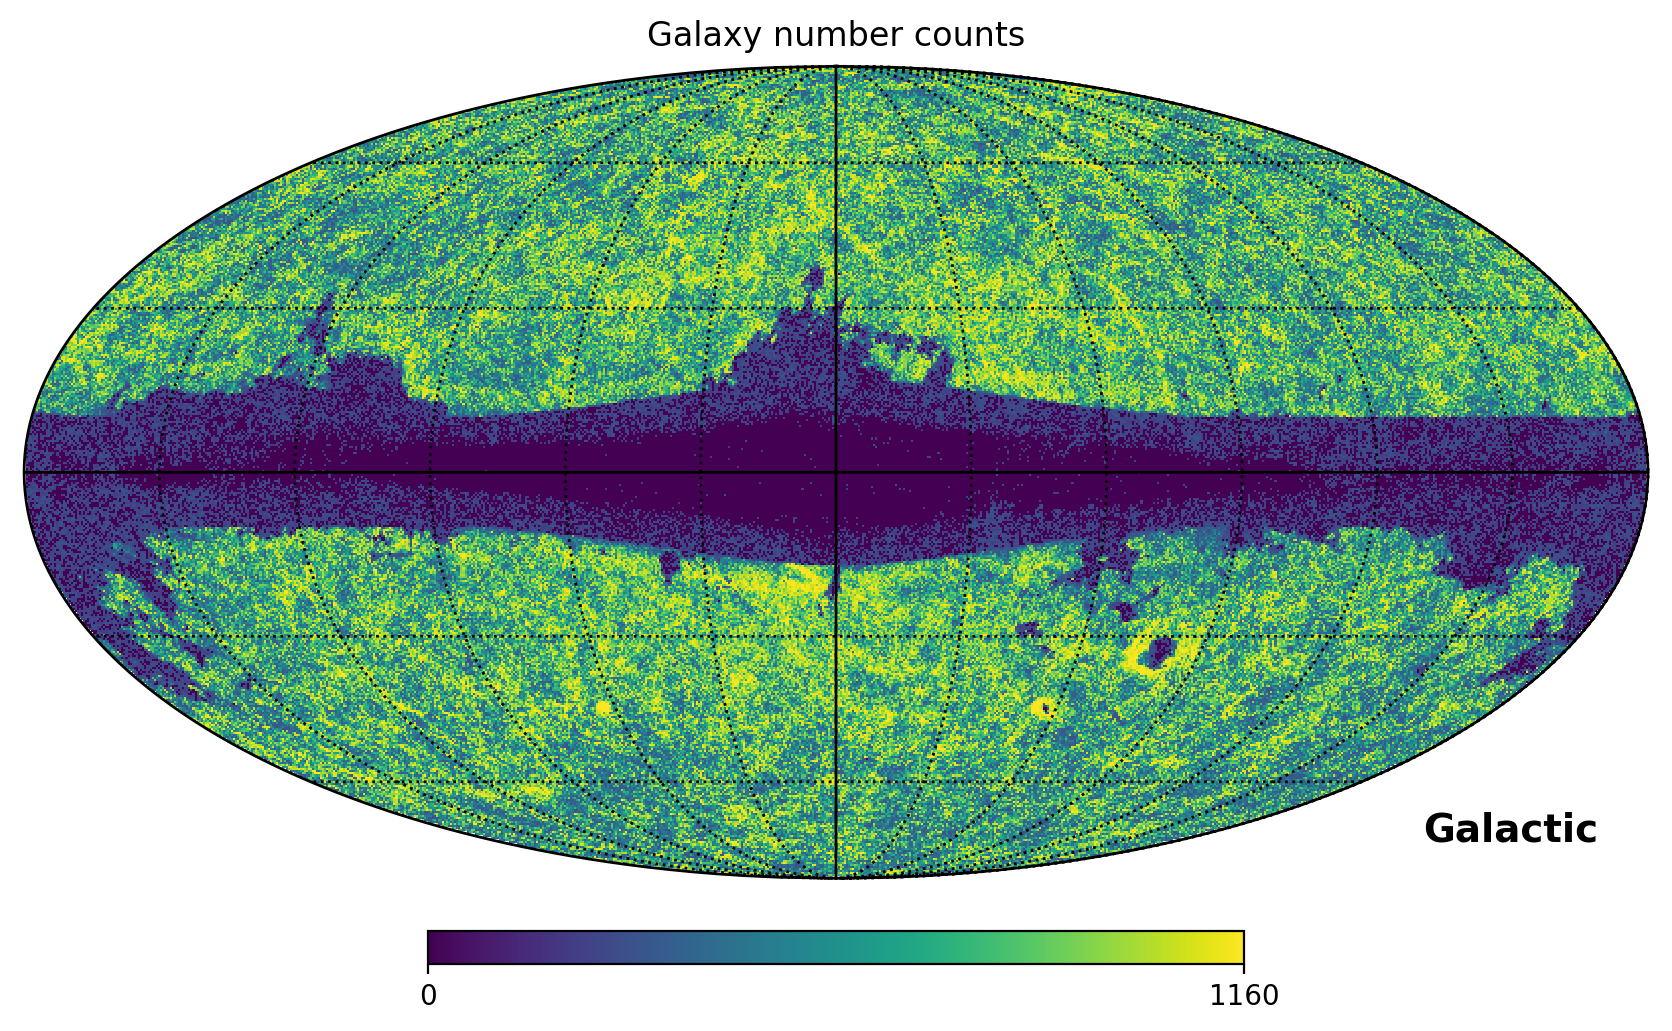

In [6]:
ra, dec = catalog.get('ra'), catalog.get('dec')
skymap = Skymap(nside, ra, dec, nest=False)
number_density = skymap.counts()
hp.mollview(number_density, title="Galaxy number counts", norm="hist", coord=['C', 'G'])
hp.graticule()
if save_figures:
    plt.savefig('figures/galaxy-map.png', dpi=400)
plt.show()

Let us create a rough mask for the galactic plane contaminant by discarding all pixels whose corresponding number density falls bellow the 30% percentile with respect to the whole  distribution:

Percentage of pixels masked: 0.70


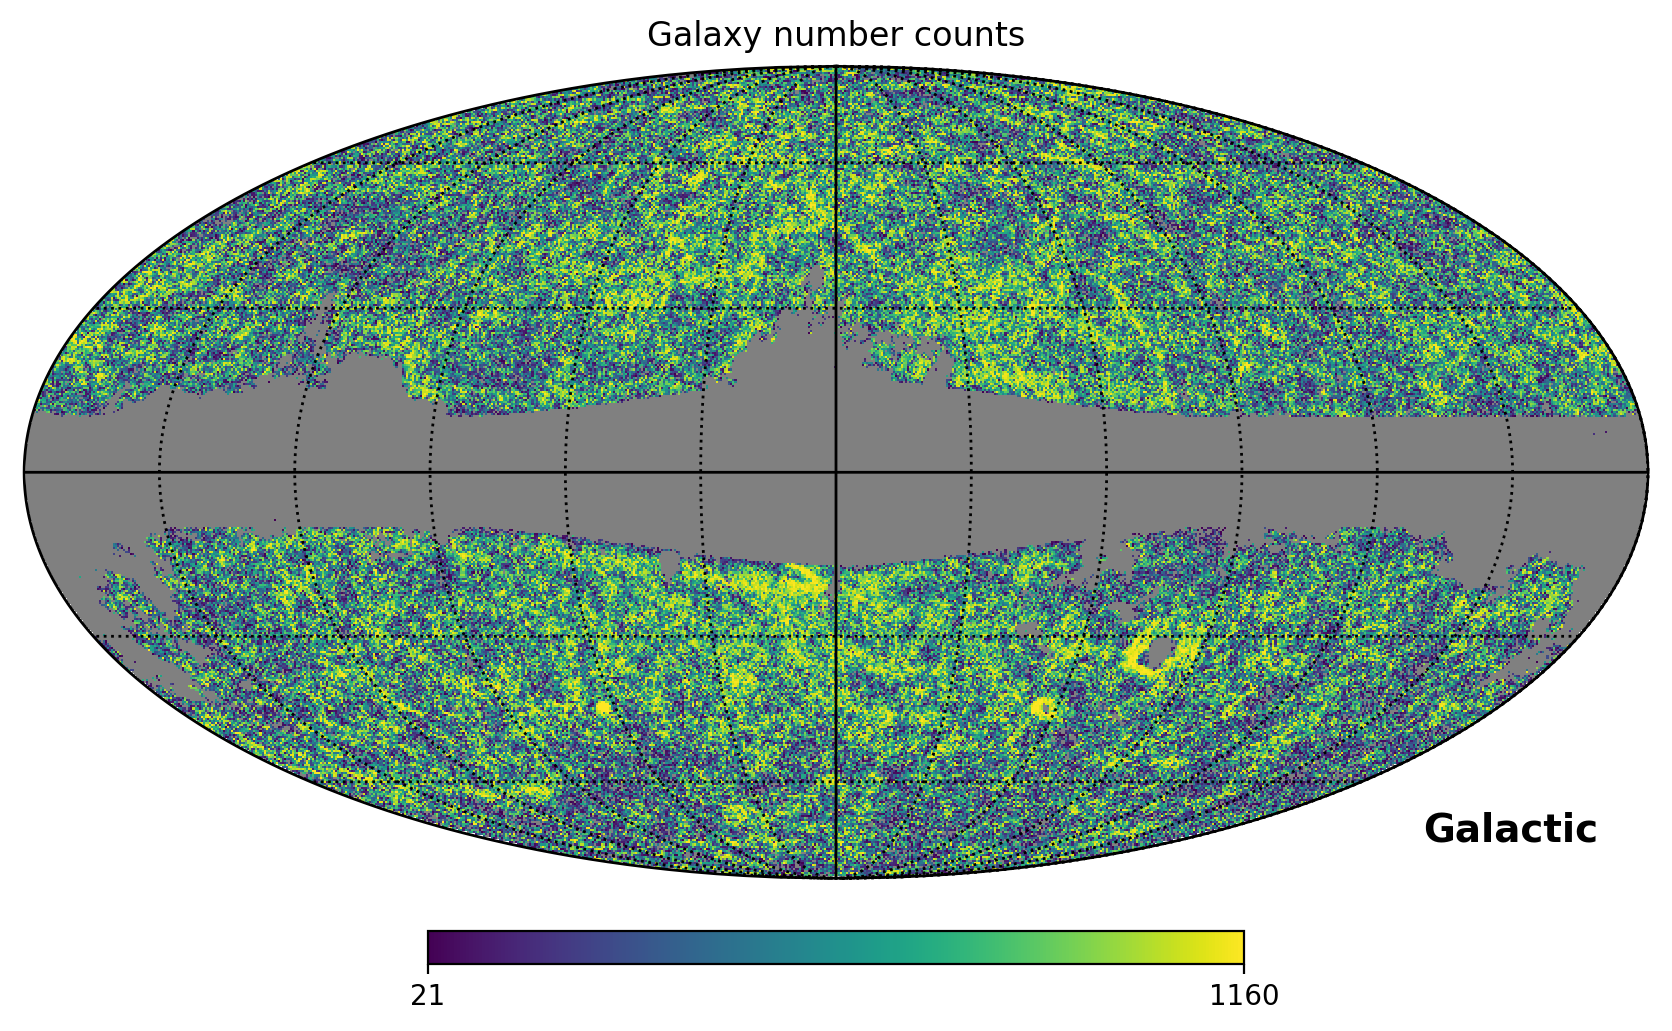

In [7]:
q = 0.30
masked_map = MaskedMap(number_density, q=q)
contaminant_mask = masked_map.mask
masked_number_density = masked_map.masked_map
fsky = masked_map.fsky
print(f'Percentage of pixels masked: {fsky:.2f}')
hp.mollview(masked_number_density, title="Galaxy number counts", norm="hist", coord=['C', 'G'])
hp.graticule()
plt.show()

Polar view of each hemisphere:

In [8]:
# # polar view
# hp.projview(
#     number_density,
#     coord=['C', "G"],
#     graticule=True,
#     graticule_labels=True,
#     unit="cbar label",
#     norm="hist",
#     cb_orientation="horizontal",
#     projection_type="polar",
#     title="Galaxy number counts",
# )
# plt.tight_layout()
# plt.show()

Histogram of the redshift distribution:

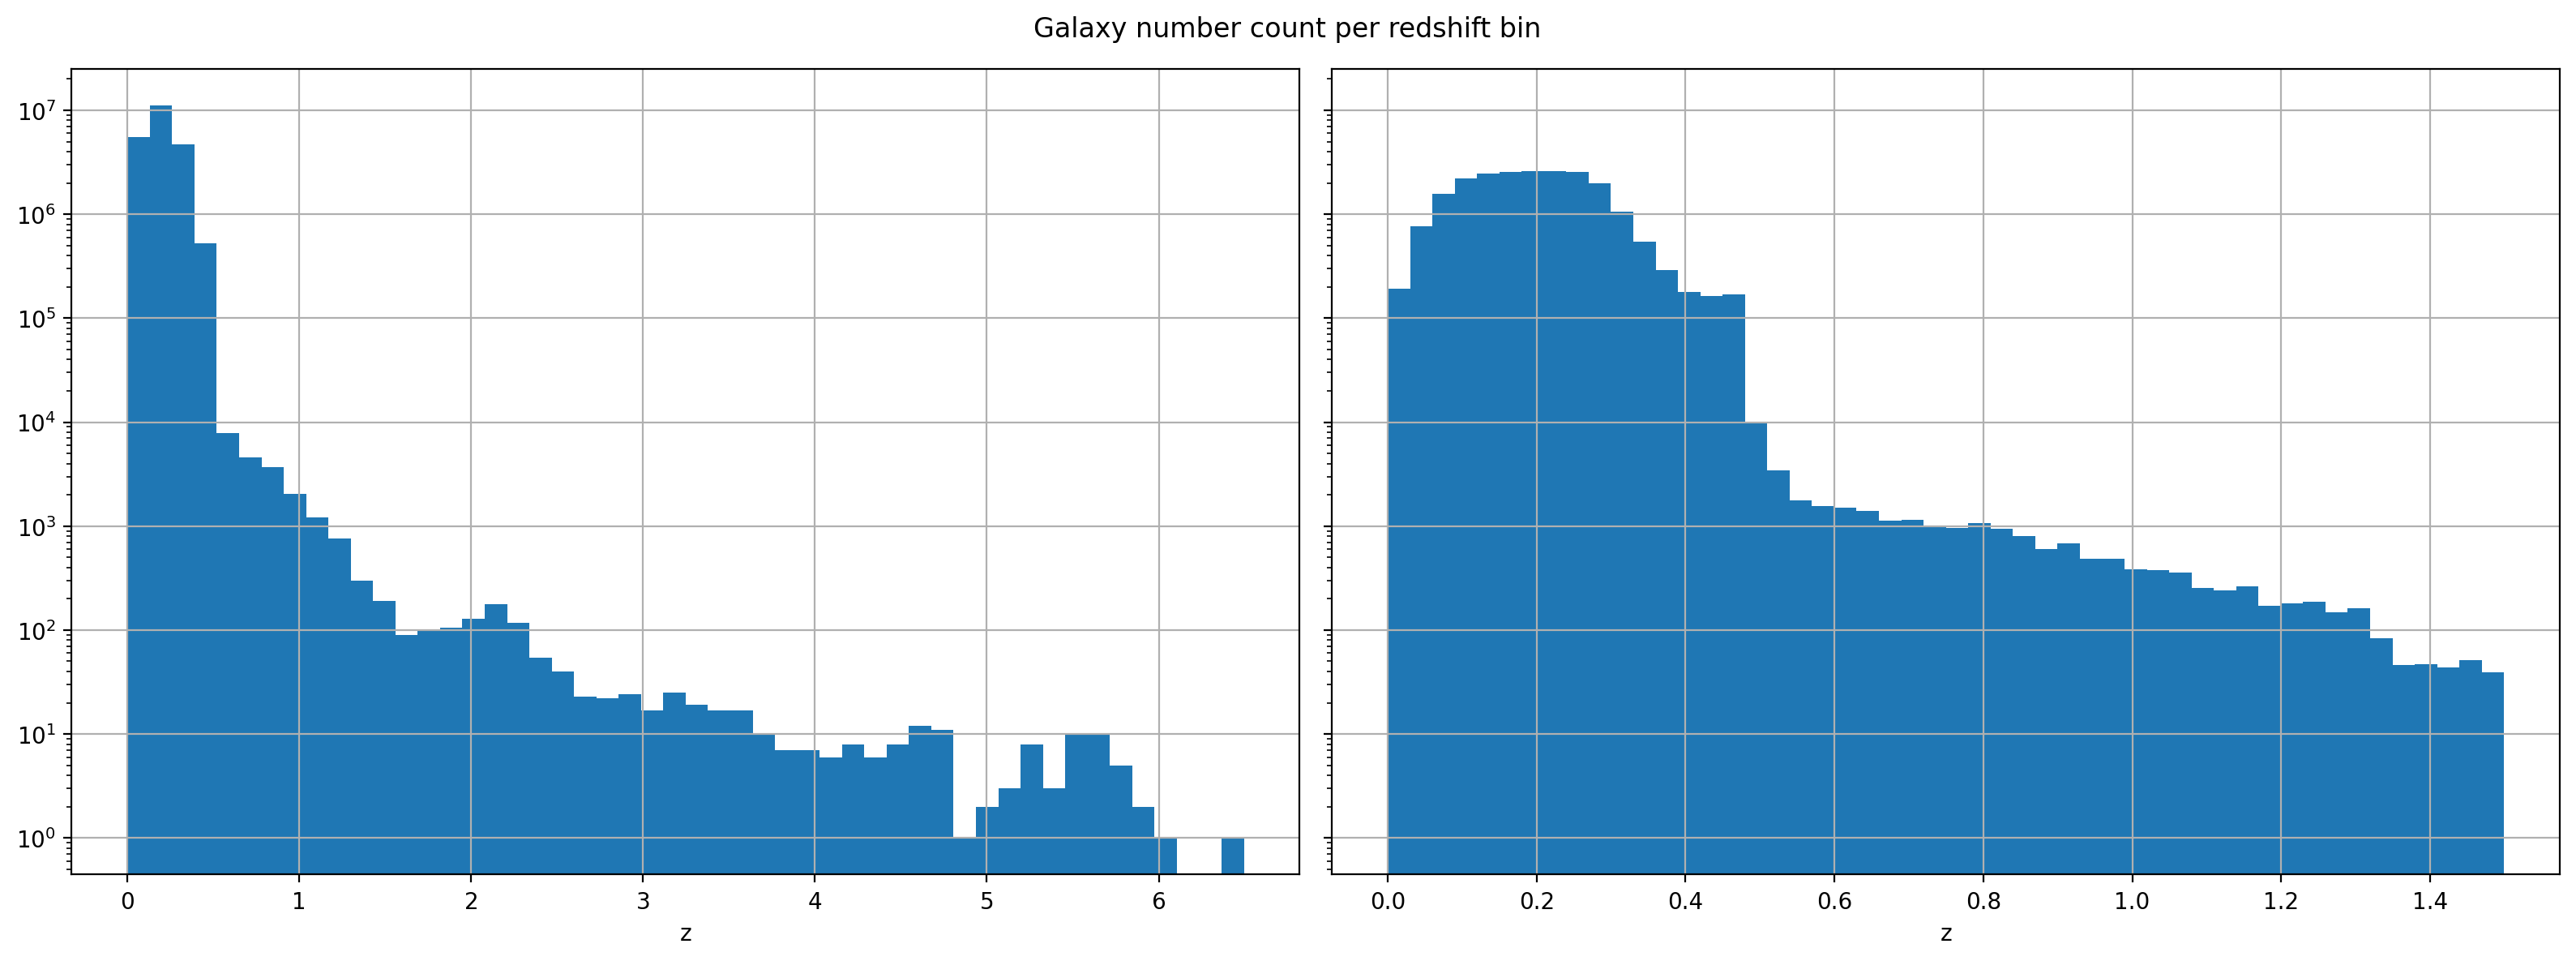

In [9]:
z = catalog.get('z_cmb')
z_max = 1.5
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
ax1.hist(z, bins=50, log=True)
ax2.hist(z[z < z_max], bins=50, log=True)
ax1.set_xlabel('z')
ax2.set_xlabel('z')
ax1.grid()
ax2.grid()
fig.suptitle('Galaxy number count per redshift bin')
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout()
if save_figures:
    fig.savefig('figures/galaxy-redshift-distribution.png', dpi=400)
plt.show()

Mergers within galaxies at $z > 1.5$ are very unlikely to be detected by current-generation detectors. Let us repeat the plot upt to $z_{\text{max}}=1.5$:

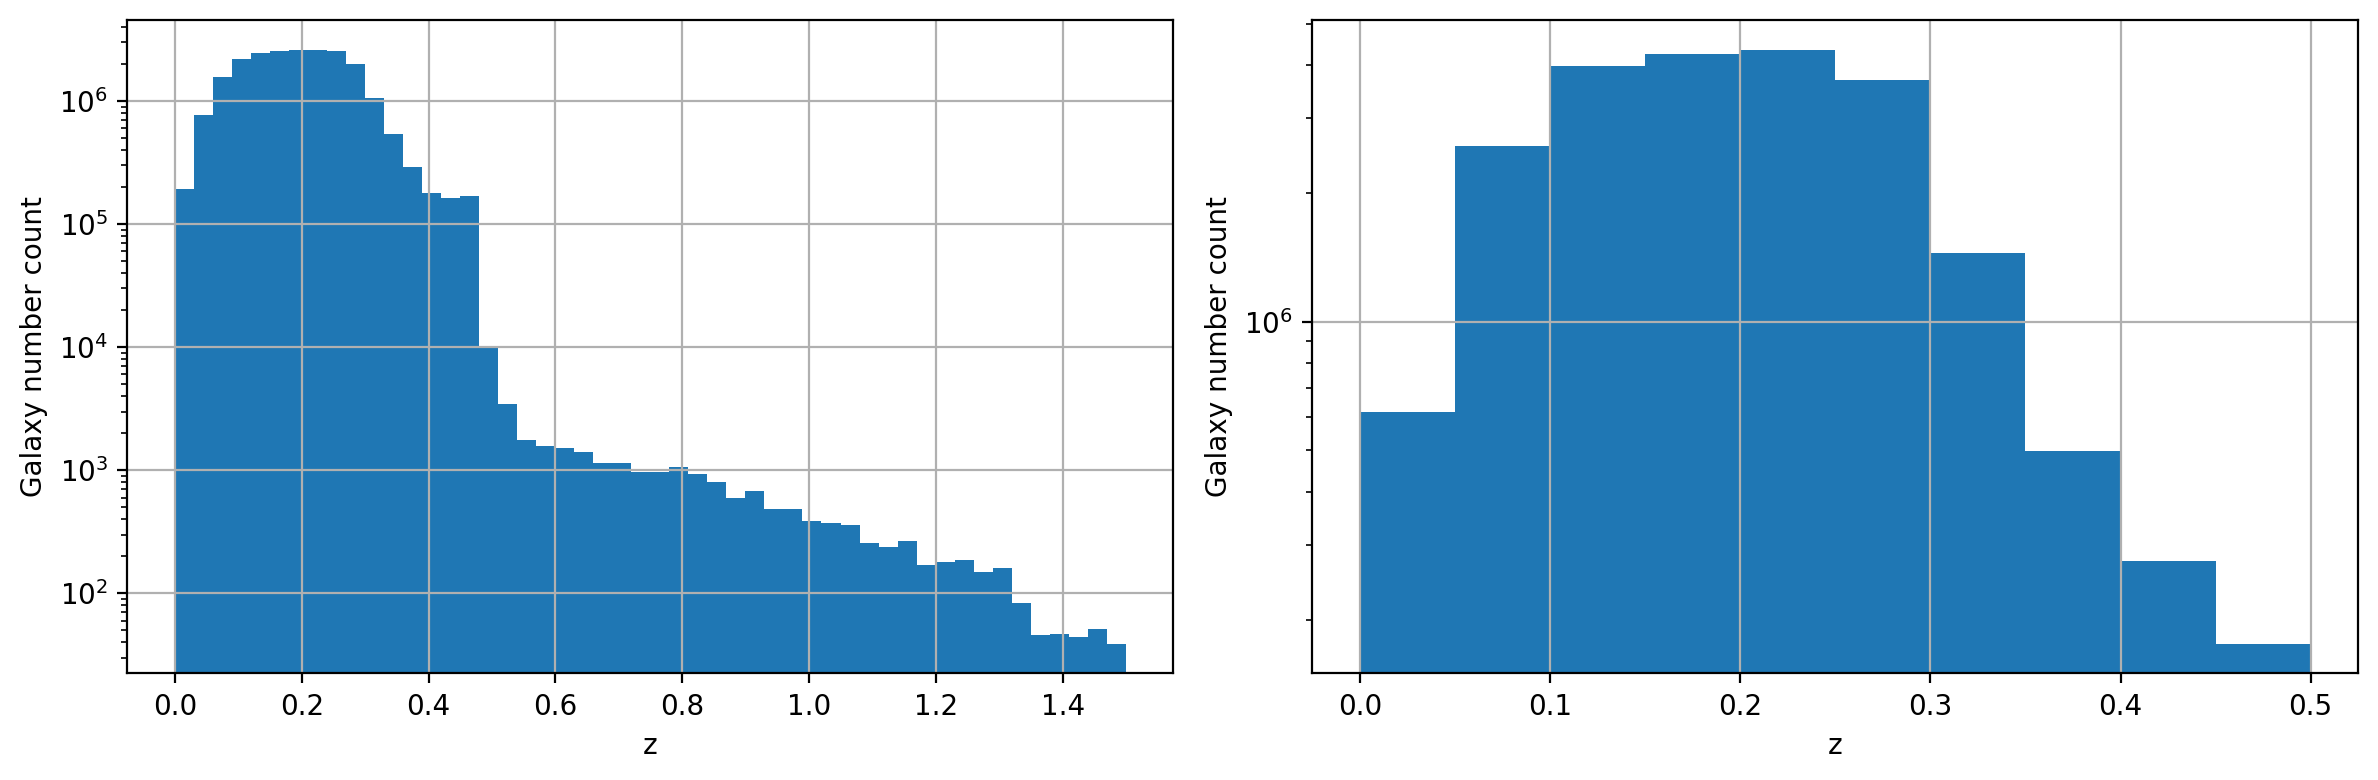

In [10]:
z = catalog.get('z_cmb')
z_max = 0.5
z_cut_mask = z < z_max
z_sample = z[z_cut_mask]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(z[z < 1.5], bins=50, log=True)
axs[1].hist(z_sample, bins=10, log=True, histtype='barstacked')
for ax in axs:
    ax.grid()
    ax.set_xlabel('z')
    ax.set_ylabel('Galaxy number count')
fig.tight_layout()
plt.show()

In [11]:
z_bins = np.arange(0., z_max, step=0.1)
nbins = len(z_bins)
print(z_bins)
masks = skymap.bin_array(z, z_bins)
ra_per_bin  = [skymap.remove_mask(ra, np.ma.mask_or(~mask, ~z_cut_mask)) for mask in masks]
dec_per_bin  = [skymap.remove_mask(dec, np.ma.mask_or(~mask, ~z_cut_mask)) for mask in masks]

full_skymap = skymap
bin_skymaps = [Skymap(nside, rabin, decbin, nest=False) for rabin, decbin in zip(ra_per_bin, dec_per_bin)]
print([len(ra_per_bin[i]) for i in range(len(z_bins))])

[0.  0.1 0.2 0.3 0.4]
[3204596, 8225083, 8031260, 1945641, 450376]


We compute the $c_\ell$ using the HEALPIX `anafast` function after removing the monopole and dipole for stability. This method is not specialized to deal with masks, and so we may expect some boundary issues. 

In [12]:
lmax = 3 * nside - 1
ell = np.arange(lmax + 1)
anafast_cls = np.empty((nbins + 1, lmax + 1))
# Compute angular power spectra for each redshift bin
for i, bin_skymap in enumerate(bin_skymaps):
    binmap = bin_skymap.counts()
    binmap = hp.remove_dipole(np.array(binmap, dtype=np.float64))
    anafast_cls[i, :] = hp.anafast(binmap, lmax=lmax, gal_cut=20, use_pixel_weights=True) / fsky

# Compute angular power spectra for the full catalog
fullmap = full_skymap.counts()
fullmap = hp.remove_dipole(np.array(fullmap, dtype=np.float64))
anafast_cls[-1, :] = hp.anafast(fullmap, lmax=lmax, gal_cut=20, use_pixel_weights=True) / fsky

Conversely, we also compute the power spectra using the `namaster` package, which is a code implementing the pseudo-$c_\ell$ method.

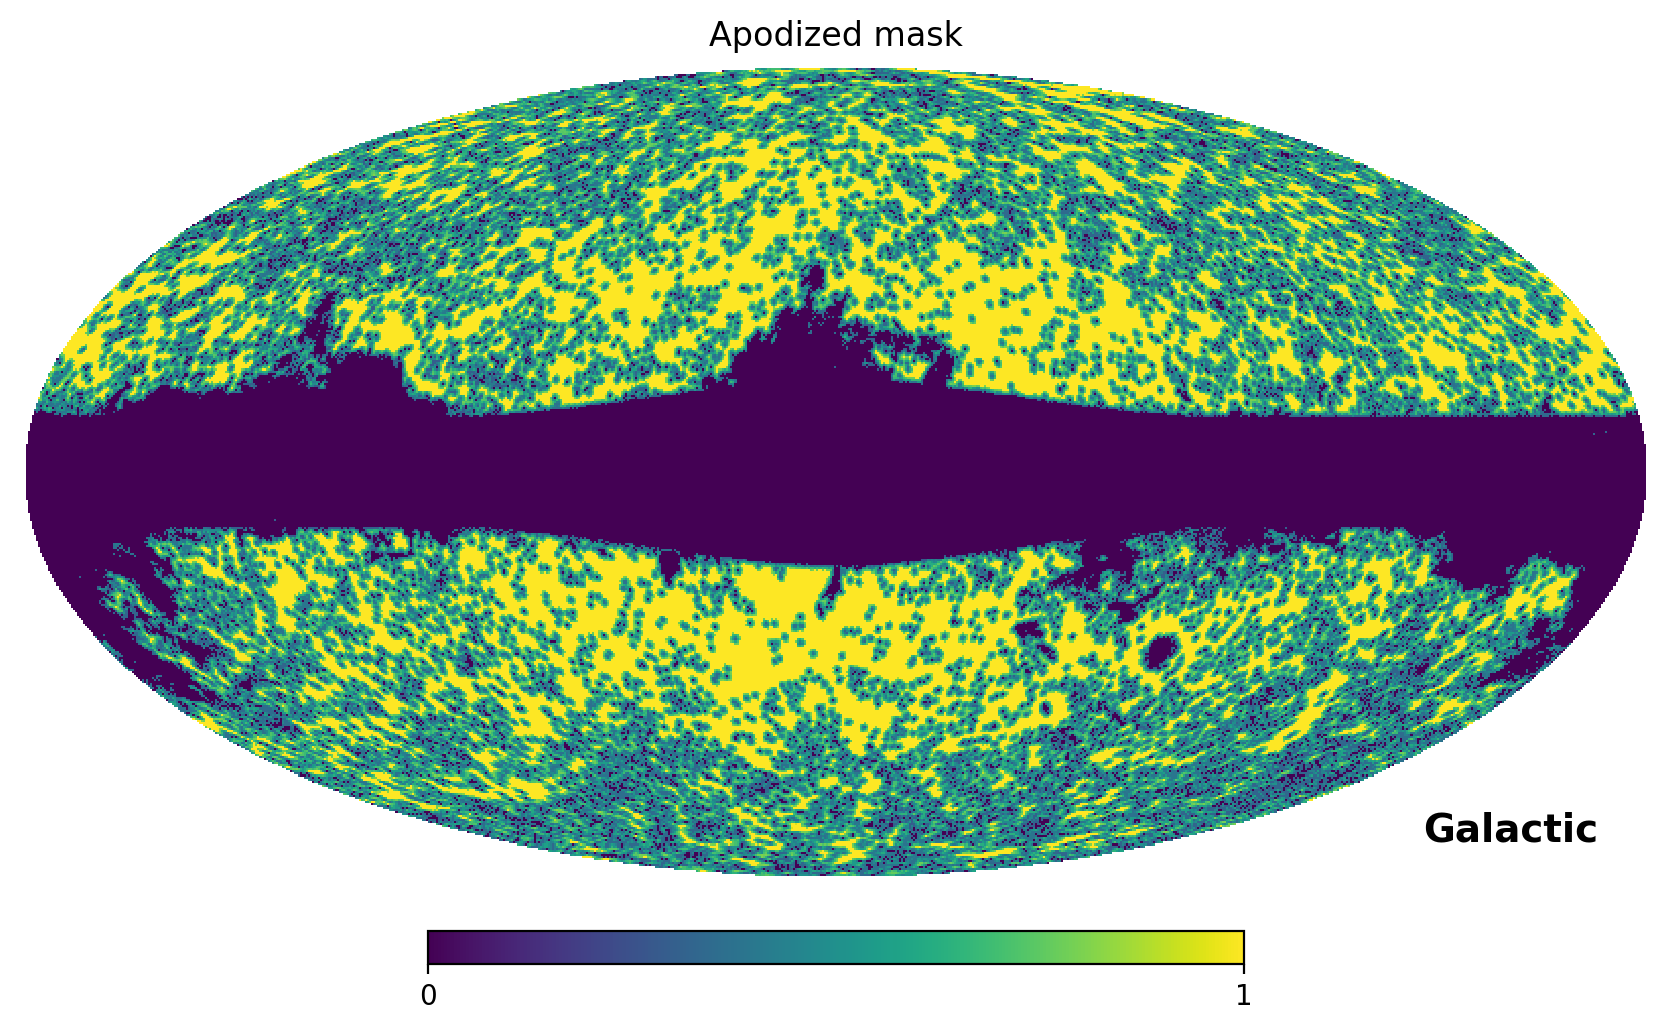

In [13]:
apodized_mask = nmt.mask_apodization(contaminant_mask, 1.)
hp.mollview(apodized_mask, title="Apodized mask", norm="hist", coord=['C', 'G'])

In [14]:
lmax = 3 * nside - 1
fields = []
# Compute angular power spectra for each redshift bin
for i, bin_skymap in enumerate(bin_skymaps):
    binmap = bin_skymap.counts().astype(np.float64)
    fields.append(nmt.NmtField(apodized_mask, [binmap]))

# Compute angular power spectra for the full catalog
fullmap = full_skymap.counts().astype(np.float64)
fields.append(nmt.NmtField(apodized_mask, [fullmap]))

Computing auto and cross angular power spectra for all bins using `namaster`:

In [15]:
l_per_bandpower = 4
nmt_bins = nmt.NmtBin.from_nside_linear(nside, l_per_bandpower)
ell = nmt_bins.get_effective_ells()
cls = np.empty((nbins + 1, nbins + 1, len(ell)))
for i, field in enumerate(fields):
    for j in range(i, nbins + 1):
        cls[i, j, :] = nmt.compute_full_master(field, fields[j], nmt_bins)

We display our results below. For each redshift bin, we plot $c_\ell$ and the rescaled $d_\ell = \ell (\ell + 1)c_\ell / 2\pi$.

nside: 256
fsky: 0.7040252685546875


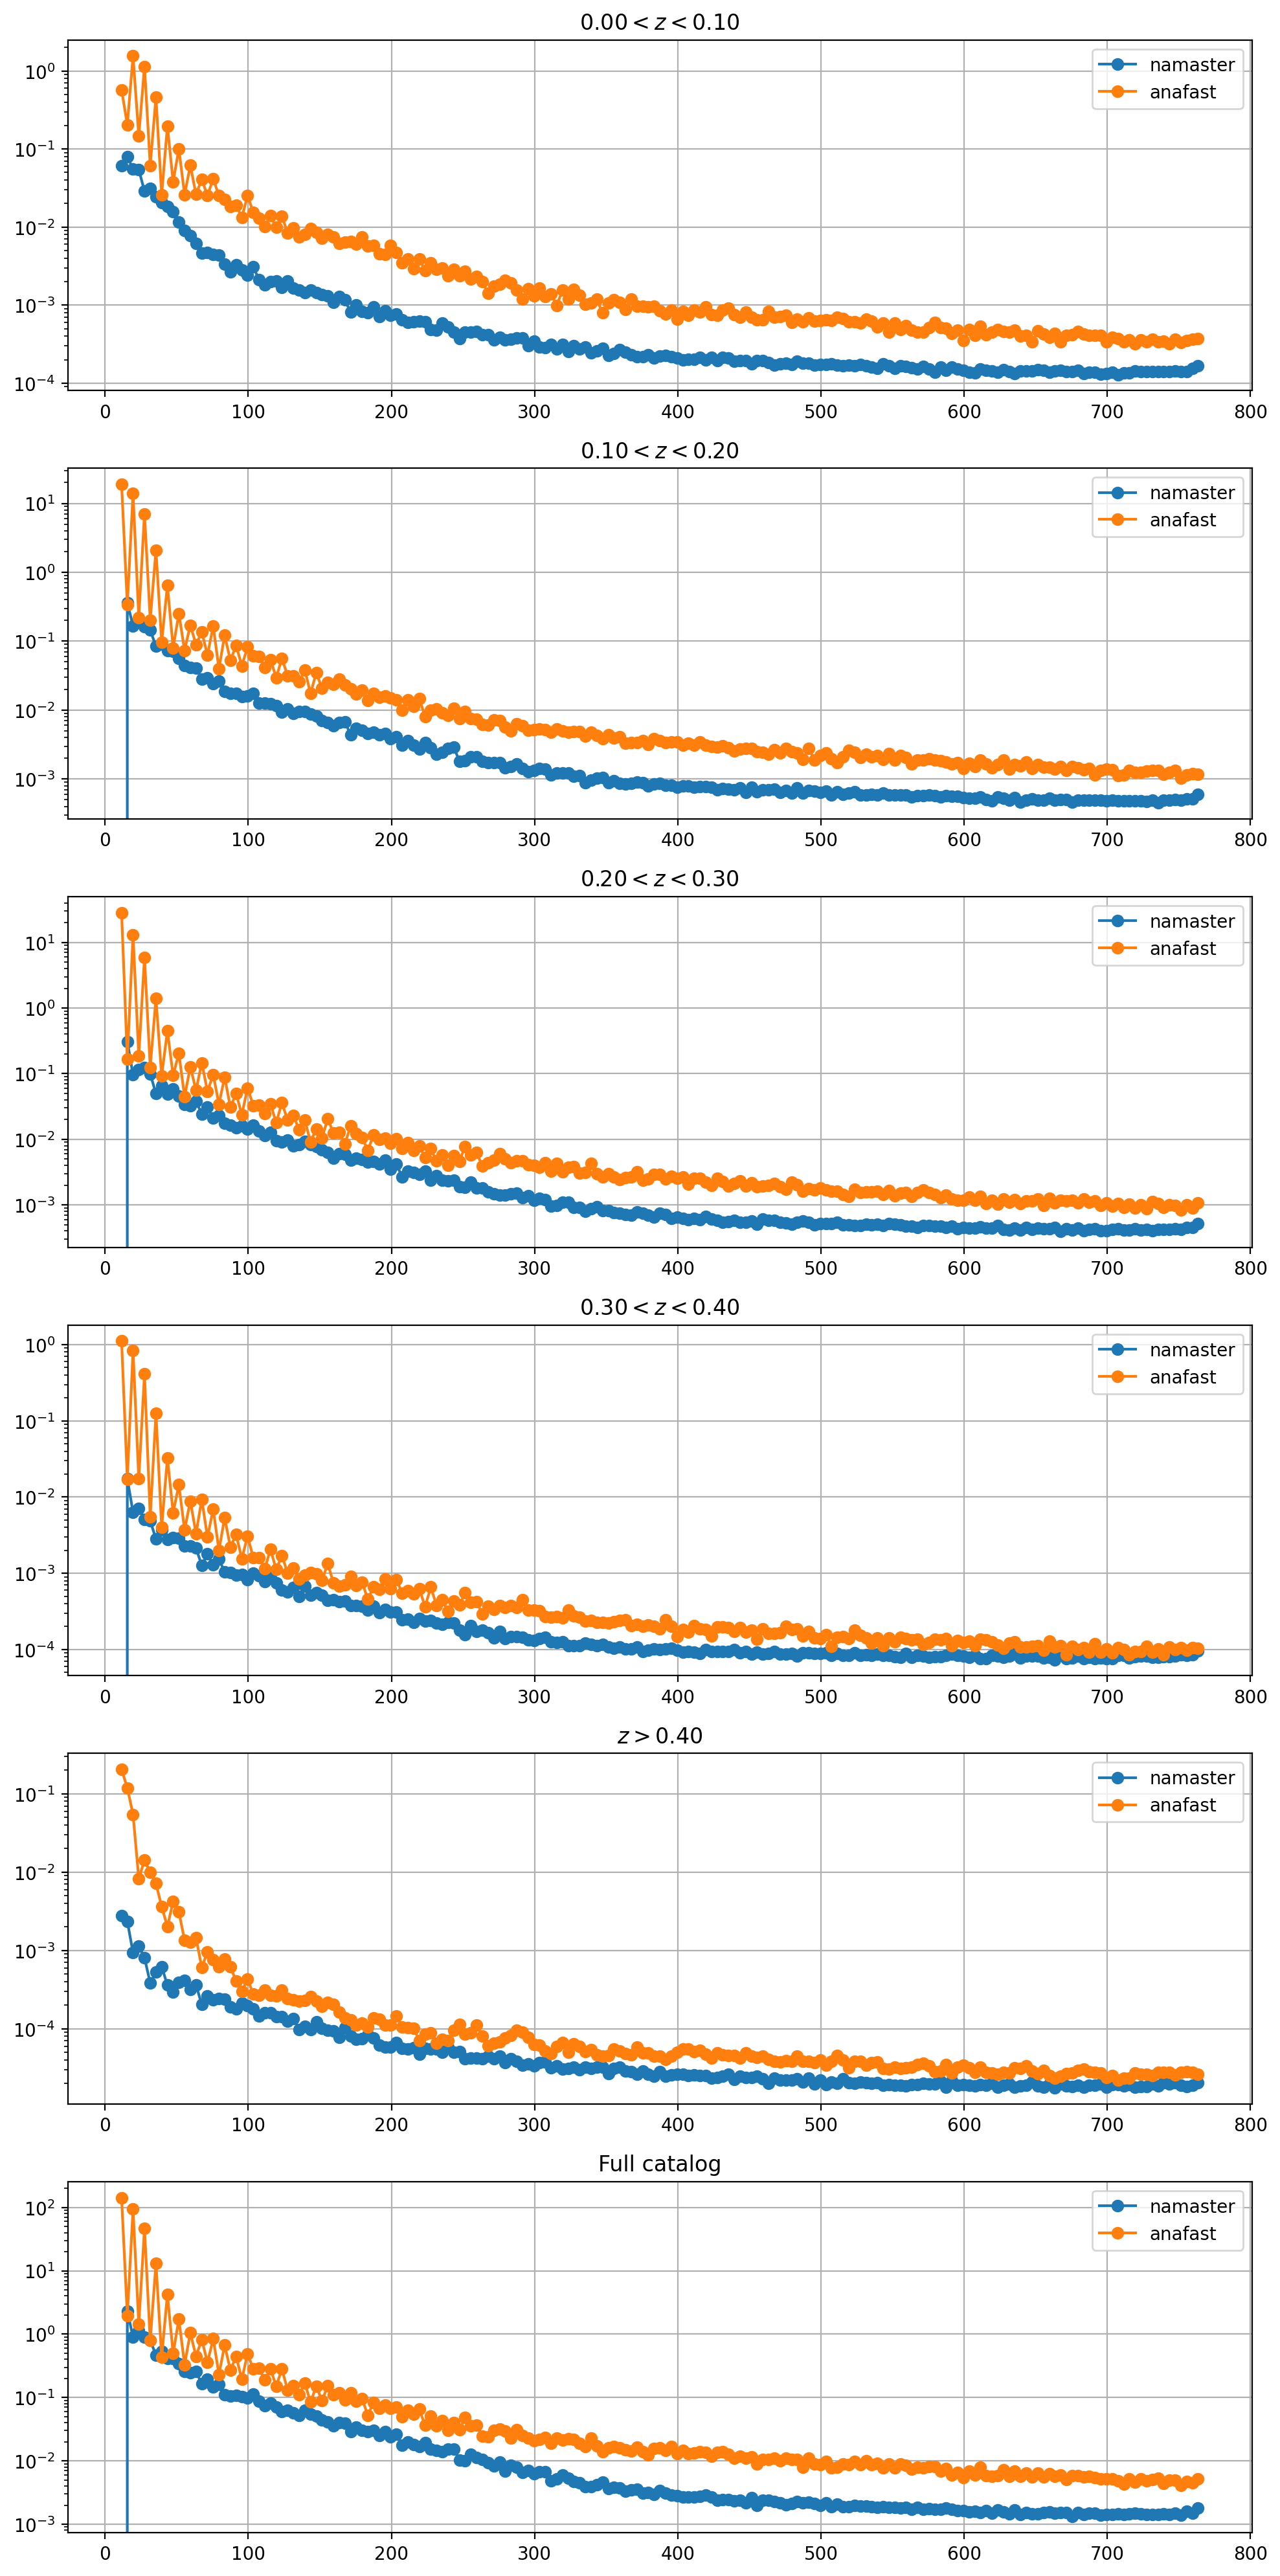

In [16]:
lshow = len(ell)
fig, axs = plt.subplots(nbins + 1, 1, figsize=(10, 20))

# Titles and labels
titles = [r'${:.2f} < z < {:.2f}$'.format(z_bins[i], z_bins[i + 1]) for i in range(nbins - 1)]
titles.append(r'$z > {:.2f}$'.format(z_bins[nbins - 1]))
titles.append('Full catalog')

for i in range(nbins + 1):
    axs[i].plot(ell[2:lshow], cls[i, i, 2:lshow], '-o', label='namaster')
    axs[i].plot(ell[2:lshow], anafast_cls[i, 2:lshow], '-o', label='anafast')
        #ax[1].plot(ell[2:lshow], (ell[2:lshow] * (ell[2:lshow] + 1) * cls[i, 2:lshow] / (2 * np.pi)), '-o')
    axs[i].set_yscale('log')
    axs[i].grid()
    axs[i].set_title(titles[i])
    axs[i].legend()
    # ax[1].set_title(titles[i])
    # ax[0].set_ylabel(r'$c_\ell$')
    # ax[1].set_ylabel(r'$d_\ell$')
    # ax[0].set_yscale('log')
    # ax[1].set_yscale('log')
    # ax[0].grid()
    # ax[1].grid()
    
print(f'nside: {nside}')
print(f'fsky: {fsky}')
fig.tight_layout()
plt.show()

We repeat the analysis with different mask apodization scales to evaluate their impact on the $c_\ell$ estimation:

In [17]:
aposizes = [1., 5., 10.]
cl_estimator = AngularPowerSpectrumEstimator(full_skymap, bin_skymaps)
cls_per_aposize = []
for aposize in aposizes:
    apodized_mask = nmt.mask_apodization(contaminant_mask, aposize)
    fields = cl_estimator.fields(apodized_mask)
    ell, cls = cl_estimator.auto_cls(l_per_bandpower, fields)
    cls_per_aposize.append(cls)

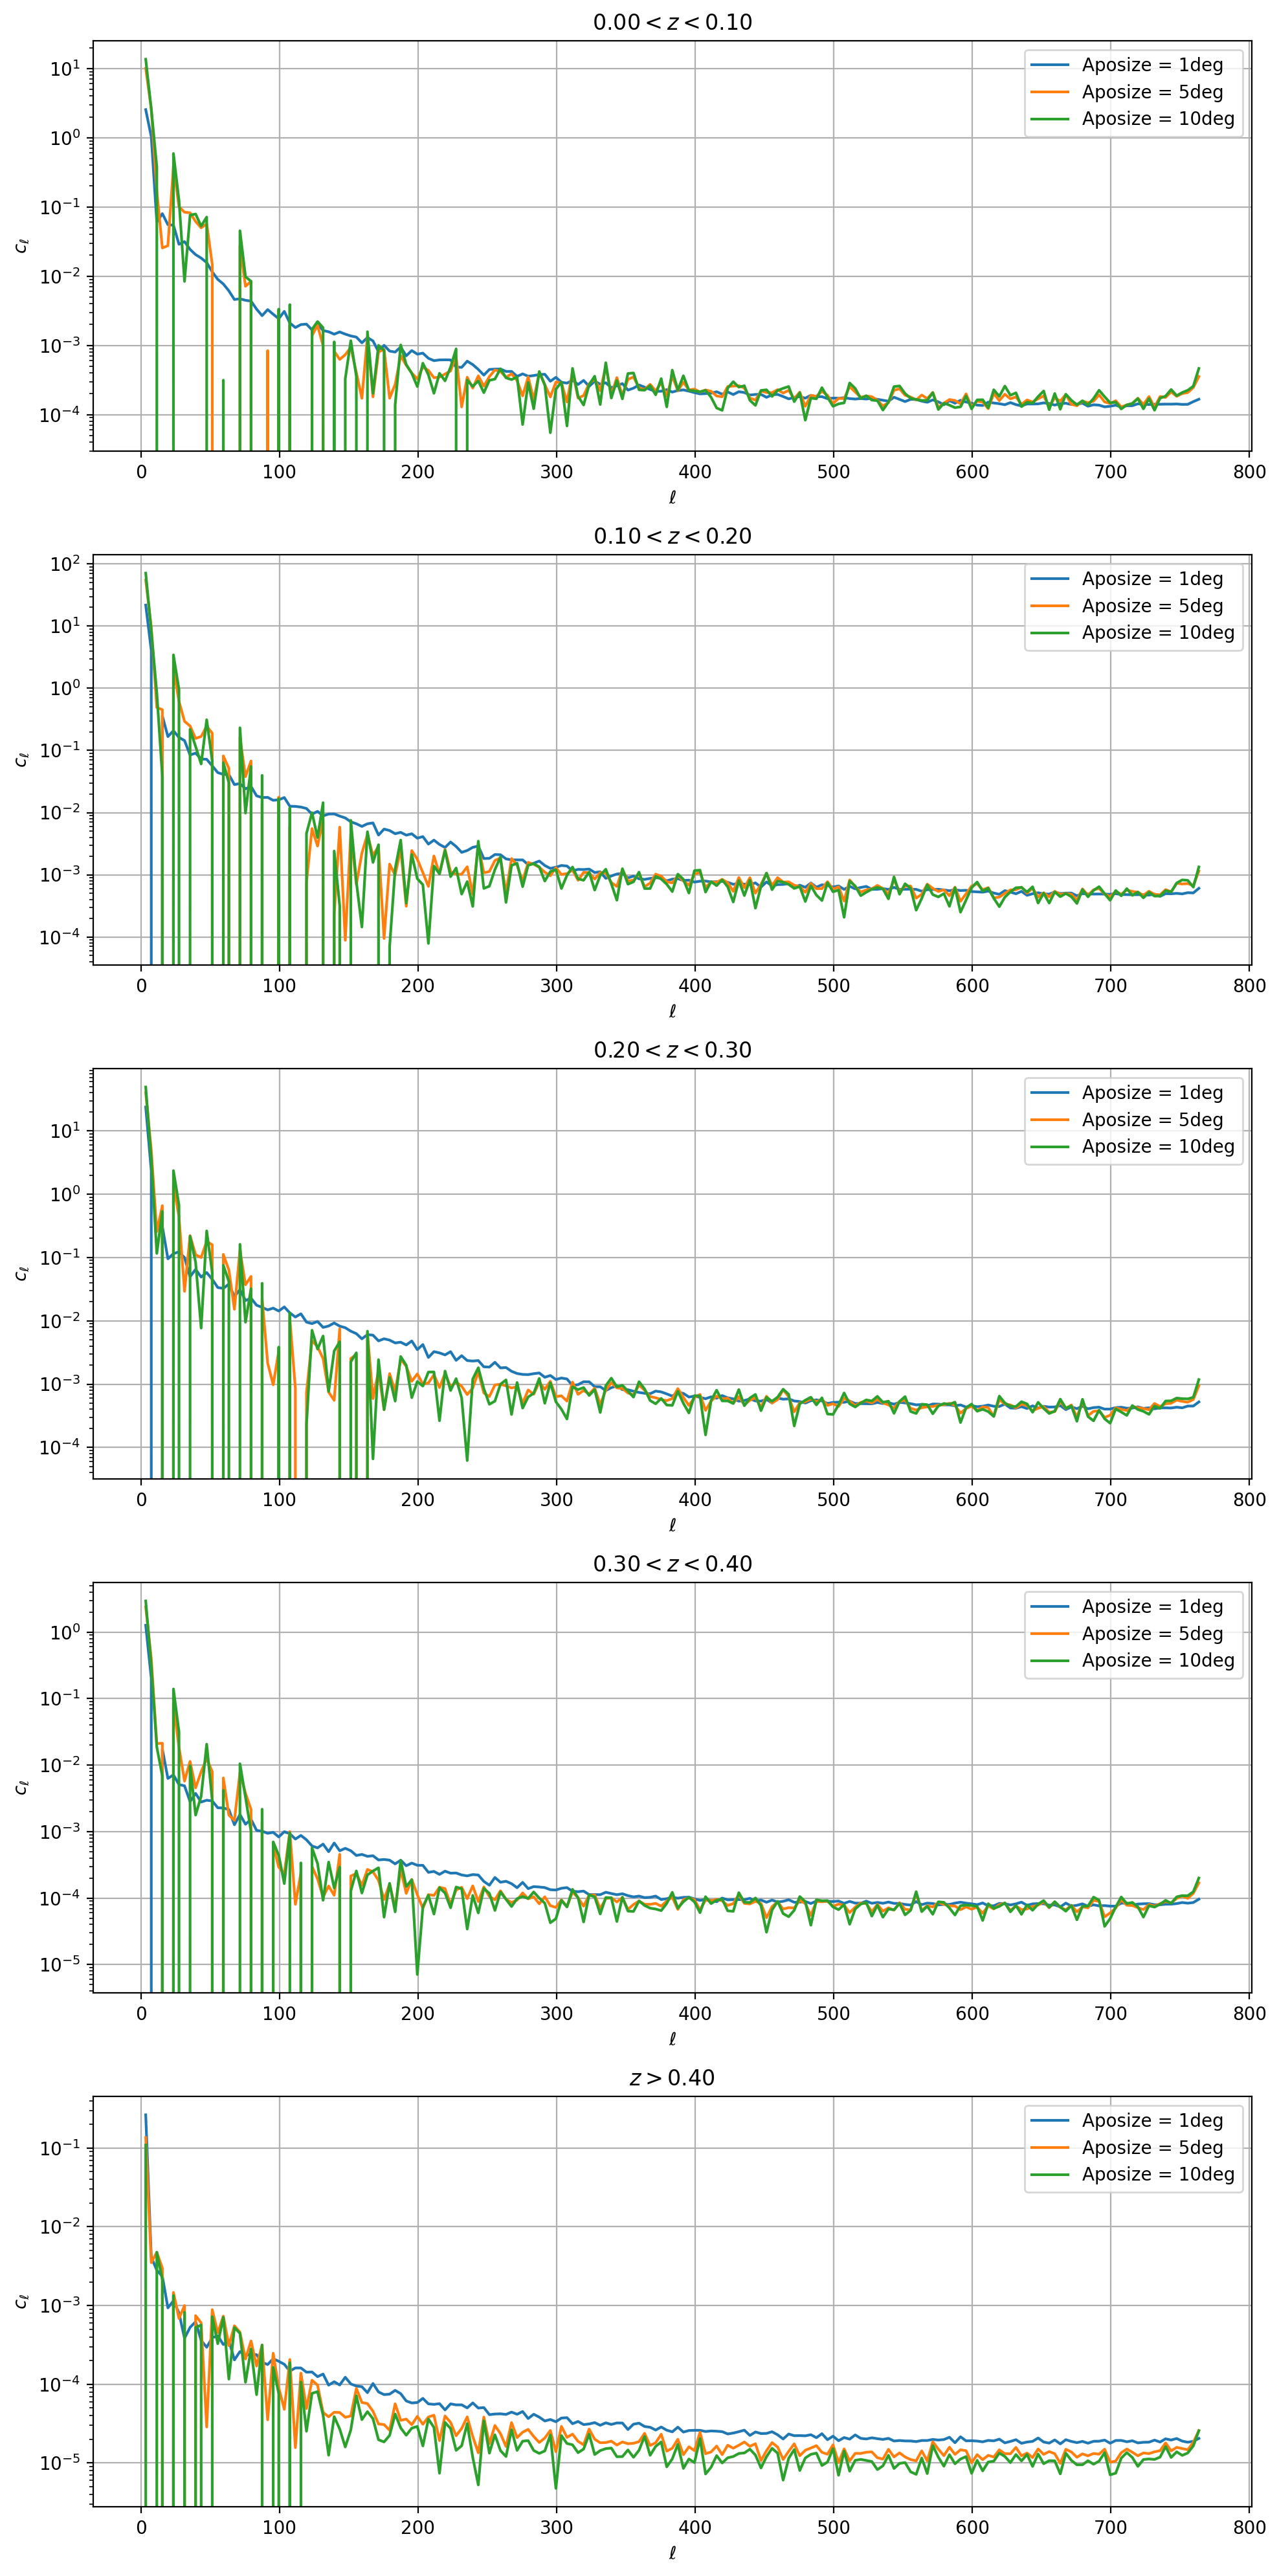

In [18]:
fig, axs = plt.subplots(nbins, 1, figsize=(10, 20))
for i, ax in enumerate(axs):
    for j, aposize in enumerate(aposizes):
        ax.plot(ell, cls_per_aposize[j][i], label=f'Aposize = {aposize:.0f}deg')
    ax.grid()
    ax.legend()
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$c_\ell$')
    ax.set_yscale('log')
    ax.set_title(titles[i])

fig.tight_layout()
plt.show()


We repeat the analysis with diferent values of the `nside` parameter to evaluate their impact on the $c_\ell$ estimation:

In [19]:
nsidevec = [64, 128, 256]
aposize = 1.
q = 0.3
cls_per_nside = []
for nside in nsidevec:
    full_skymap = Skymap(nside, ra, dec, nest=False)
    bin_skymaps = [Skymap(nside, rabin, decbin, nest=False) for rabin, decbin in zip(ra_per_bin, dec_per_bin)]
    cl_estimator = AngularPowerSpectrumEstimator(full_skymap, bin_skymaps)
    fullmap = full_skymap.counts()
    masked_map = MaskedMap(fullmap, q=q)
    apodized_mask = nmt.mask_apodization(masked_map.mask, aposize)
    fields = cl_estimator.fields(apodized_mask)
    ell, cls = cl_estimator.auto_cls(l_per_bandpower, fields)
    cls_per_nside.append(cls)

: 

In [ ]:
fig, axs = plt.subplots(nbins, 1, figsize=(10, 20))
for i, ax in enumerate(axs):
    for j, nside in enumerate(nsidevec):
        ax.plot(ell, cls_per_nside[j][i], label=f'nside = {nside:.2f}')
    ax.grid()
    ax.legend()
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$c_\ell$')
    ax.set_yscale('log')
    ax.set_title(titles[i])

fig.tight_layout()
plt.show()
